The first step towards fitting a linear regression with time series modeling is setting up your workspace with the appropriate packages, and loading in the needed data. 

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv('data/train.csv',
    dtype=dtype,
    parse_dates=['date']
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']


Fitting a linear regression with a time-step feature:

In [3]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()
time =  np.arange(len(df))

df['time'] = time 

X = df[['time']]  
y = df[['sales']] 

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X)[:,0], index=X.index)
print(y_pred)

date
2013-01-01    194.232790
2013-01-02    194.427137
2013-01-03    194.621484
2013-01-04    194.815831
2013-01-05    195.010178
                 ...    
2017-08-11    520.541320
2017-08-12    520.735667
2017-08-13    520.930014
2017-08-14    521.124361
2017-08-15    521.318708
Freq: D, Length: 1684, dtype: float64


Fitting a linear regression with lag features:

In [6]:
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
print(y_pred)

date
2013-01-02     85.301689
2013-01-03    297.268250
2013-01-04    239.451340
2013-01-05    236.444550
2013-01-06    289.219421
                 ...    
2017-08-11    363.958893
2017-08-12    439.106384
2017-08-13    424.615509
2017-08-14    455.968994
2017-08-15    410.998535
Freq: D, Length: 1683, dtype: float32


Plot the results

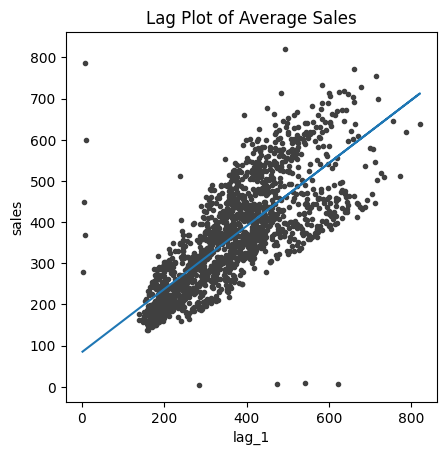

In [9]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');